In [2]:
# Core libraries
import os
import zipfile
import random
import shutil


# Data handling & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


# Deep Learning / Computer Vision
import torch


# YOLOv8
!pip install -q ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check GPU availability
if torch.cuda.is_available():
    print("GPU Available:", torch.cuda.get_device_name(0))
else:
    print("GPU NOT available – training will run on CPU")

GPU NOT available – training will run on CPU


In [4]:
# Install kagglehub to download dataset directly without manual upload
!pip install -q kagglehub


import kagglehub


# Download dataset
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")
print("Dataset downloaded at:", path)

Using Colab cache for faster access to the 'car-plate-detection' dataset.
Dataset downloaded at: /kaggle/input/car-plate-detection


/kaggle/input/car-plate-detection


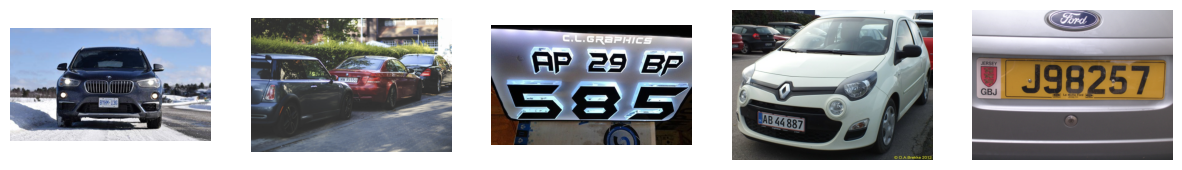

In [5]:
# Explore dataset structure
for root, dirs, files in os.walk(path):
    print(root)
    break


# Paths
images_path = os.path.join(path, "images")
labels_path = os.path.join(path, "annotations")


# Display random images
sample_images = random.sample(os.listdir(images_path), 5)

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(images_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


In [6]:
# YOLOv8 expects specific directory structure
import os
import shutil
import random
import cv2 # Ensure cv2 is imported for image reading
import xml.etree.ElementTree as ET

# Corrected paths based on the actual downloaded Kaggle dataset
# 'path' is already defined from kagglehub.dataset_download in cell wqe0QnE3aktn
# 'images_path' and 'labels_path' are already defined in cell eTk3fPcFaoRO

images_source_path = images_path # /kaggle/input/car-plate-detection/images
# No longer looking for a single annotations.xml, but iterating through individual ones

# --- Diagnostic Prints ---
print(f"Checking path: {path}")
if os.path.exists(path):
    print(f"Contents of {path}: {os.listdir(path)}")
else:
    print(f"Directory {path} does not exist.")

print(f"Checking labels_path: {labels_path}")
if os.path.exists(labels_path):
    print(f"Contents of {labels_path}: {os.listdir(labels_path)}")
else:
    print(f"Directory {labels_path} does not exist.")

# Base directory for the new YOLOv8 dataset structure
base_dir = "/content/plate_dataset"

# Create base directories for YOLOv8 format
for split in ["train", "val"]:
    os.makedirs(f"{base_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_dir}/labels/{split}", exist_ok=True)

yolo_annotations = {}
image_filepaths = {} # Map filename to its full path for symlinking

# --- Parse individual XML annotation files ---
parsed_xml_count = 0
for annotation_file in os.listdir(labels_path):
    if annotation_file.endswith('.xml'):
        annotation_xml_path = os.path.join(labels_path, annotation_file)
        try:
            tree = ET.parse(annotation_xml_path)
            root_xml = tree.getroot()

            filename = root_xml.find("filename").text
            img_width = int(root_xml.find("size/width").text)
            img_height = int(root_xml.find("size/height").text)

            boxes = []
            for obj in root_xml.findall("object"):
                # The class name is 'number_plate', which corresponds to class_id 0 in data.yaml
                class_id = 0

                bndbox = obj.find("bndbox")
                xmin = float(bndbox.find("xmin").text)
                ymin = float(bndbox.find("ymin").text)
                xmax = float(bndbox.find("xmax").text)
                ymax = float(bndbox.find("ymax").text)

                # Convert to YOLO format (normalized center_x, center_y, width, height)
                box_width = xmax - xmin
                box_height = ymax - ymin
                x_center = (xmin + xmax) / 2
                y_center = (ymin + ymax) / 2

                # Normalize coordinates
                x_center_norm = x_center / img_width
                y_center_norm = y_center / img_height
                width_norm = box_width / img_width
                height_norm = box_height / img_height

                boxes.append(f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}")

            yolo_annotations[filename] = boxes
            image_filepaths[filename] = os.path.join(images_source_path, filename) # Store for symlinking
            parsed_xml_count += 1
        except Exception as e:
            print(f"WARNING: Error parsing {annotation_file}: {e}")

print(f"Parsed annotations for {parsed_xml_count} unique images from individual XML files.")

# Filter images to only include those that were successfully annotated
image_files_with_annotations = list(yolo_annotations.keys())
if not image_files_with_annotations:
    print("No valid annotations found. Exiting dataset preparation.")
    raise ValueError("No valid annotations found. Cannot proceed with dataset preparation.")

random.shuffle(image_files_with_annotations)

# --- Simple train/val split ---
split_ratio = 0.8 # 80% for training
split_index = int(split_ratio * len(image_files_with_annotations))
train_files = image_files_with_annotations[:split_index]
val_files = image_files_with_annotations[split_index:]

print(f"Total images with valid annotations: {len(image_files_with_annotations)}")
print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

# --- Create symbolic links and YOLO label files ---
for file_list, split in [(train_files, "train"), (val_files, "val")]:
    for img_name in file_list:
        # Create symbolic link for image
        source_image_path = image_filepaths.get(img_name)
        if source_image_path and os.path.exists(source_image_path):
            target_image_dir = os.path.join(base_dir, "images", split)
            target_image_path = os.path.join(target_image_dir, img_name)
            # Use os.symlink for space saving as requested
            os.makedirs(target_image_dir, exist_ok=True)
            if not os.path.exists(target_image_path): # Avoid creating duplicate symlinks
                os.symlink(source_image_path, target_image_path)
            # else: # Removed this print to avoid excessive output if symlinks are already there
            #     print(f"Skipping symlink for {img_name}: target already exists.")
        else:
            print(f"WARNING: Source image for {img_name} not found or path invalid. Skipping symlink.")

        # Create YOLO label file
        label_output_path = os.path.join(base_dir, "labels", split, os.path.splitext(img_name)[0] + '.txt')
        if img_name in yolo_annotations and yolo_annotations[img_name]:
            with open(label_output_path, "w") as f:
                f.write("\n".join(yolo_annotations[img_name]))
        else:
            print(f"WARNING: No YOLO annotations found for {img_name} or annotations list is empty. Skipping label file creation.")

print("Preprocessing completed based on individual XML files and symbolic links.")

Checking path: /kaggle/input/car-plate-detection
Contents of /kaggle/input/car-plate-detection: ['annotations', 'images']
Checking labels_path: /kaggle/input/car-plate-detection/annotations
Contents of /kaggle/input/car-plate-detection/annotations: ['Cars339.xml', 'Cars13.xml', 'Cars74.xml', 'Cars16.xml', 'Cars291.xml', 'Cars236.xml', 'Cars429.xml', 'Cars132.xml', 'Cars251.xml', 'Cars51.xml', 'Cars165.xml', 'Cars313.xml', 'Cars240.xml', 'Cars201.xml', 'Cars412.xml', 'Cars227.xml', 'Cars145.xml', 'Cars203.xml', 'Cars131.xml', 'Cars423.xml', 'Cars123.xml', 'Cars189.xml', 'Cars175.xml', 'Cars30.xml', 'Cars197.xml', 'Cars99.xml', 'Cars191.xml', 'Cars168.xml', 'Cars239.xml', 'Cars26.xml', 'Cars115.xml', 'Cars119.xml', 'Cars395.xml', 'Cars96.xml', 'Cars231.xml', 'Cars422.xml', 'Cars192.xml', 'Cars389.xml', 'Cars409.xml', 'Cars107.xml', 'Cars147.xml', 'Cars77.xml', 'Cars420.xml', 'Cars196.xml', 'Cars73.xml', 'Cars343.xml', 'Cars3.xml', 'Cars295.xml', 'Cars392.xml', 'Cars314.xml', 'Cars261.xml

In [7]:
# Load pre-trained YOLOv8 nano model
model = YOLO("yolov8n.pt")


# Dataset configuration file
data_yaml = """
path: /content/plate_dataset
train: images/train
val: images/val

nc: 1
names: ['number_plate']
"""


with open("data.yaml", "w") as f:
    f.write(data_yaml)

In [8]:
# Train the model
model.train(
data="data.yaml",
epochs=10,
imgsz=640,
batch=8
)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9bd5c5edb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [9]:
# Evaluate trained model
metrics = model.val()
print(metrics)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 574.7±198.4 MB/s, size: 533.6 KB)
val: Scanning /content/plate_dataset/labels/val.cache... 87 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 87/87 60.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 2.6s/it 15.7s
                   all         87        100      0.796       0.84      0.861      0.487
Speed: 1.2ms preprocess, 151.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9bd235cec0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Prec


image 1/87 /content/plate_dataset/images/val/Cars0.png: 352x640 1 number_plate, 123.1ms
image 2/87 /content/plate_dataset/images/val/Cars101.png: 480x640 1 number_plate, 154.3ms
image 3/87 /content/plate_dataset/images/val/Cars106.png: 416x640 3 number_plates, 139.4ms
image 4/87 /content/plate_dataset/images/val/Cars110.png: 448x640 (no detections), 147.9ms
image 5/87 /content/plate_dataset/images/val/Cars113.png: 480x640 2 number_plates, 147.0ms
image 6/87 /content/plate_dataset/images/val/Cars114.png: 384x640 2 number_plates, 131.1ms
image 7/87 /content/plate_dataset/images/val/Cars118.png: 416x640 1 number_plate, 130.0ms
image 8/87 /content/plate_dataset/images/val/Cars122.png: 480x640 1 number_plate, 143.7ms
image 9/87 /content/plate_dataset/images/val/Cars123.png: 480x640 1 number_plate, 179.5ms
image 10/87 /content/plate_dataset/images/val/Cars124.png: 448x640 3 number_plates, 233.0ms
image 11/87 /content/plate_dataset/images/val/Cars125.png: 416x640 1 number_plate, 202.2ms
imag

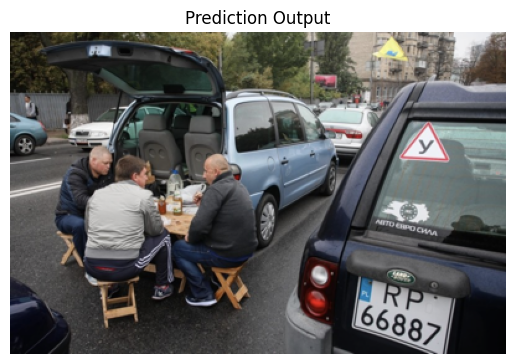

In [10]:
# Run prediction on validation images
results = model.predict(source=f"{base_dir}/images/val", save=True)


# Show sample prediction
sample_img = random.choice(os.listdir(f"{base_dir}/images/val"))
img = cv2.imread(f"{base_dir}/images/val/{sample_img}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.imshow(img)
plt.title("Prediction Output")
plt.axis('off')
plt.show()


0: 640x640 1 number_plate, 198.1ms
1: 640x640 (no detections), 198.1ms
2: 640x640 1 number_plate, 198.1ms
Speed: 3.7ms preprocess, 198.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


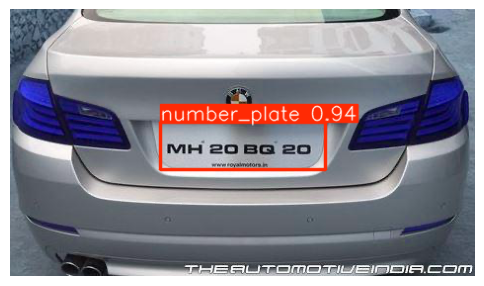

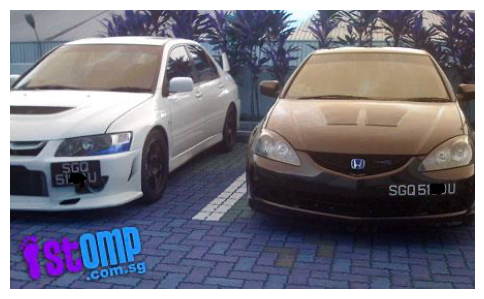

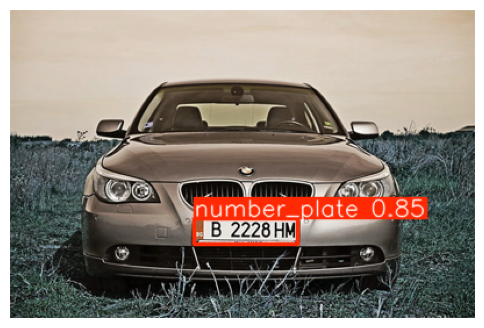

In [11]:


import glob  # Add this line at the top

# Select 3 random test images
# Correcting the path to base_dir
test_images = random.sample(glob.glob(f"{base_dir}/images/val/*.png"), 3)

# Run prediction using trained YOLO model
results = model.predict(test_images, conf=0.5)

# Visualize predictions
for r in results:
    plt.figure(figsize=(6, 4))
    plt.imshow(r.plot())  # r.plot() draws bounding boxes
    plt.axis("off")
    plt.show()

In [12]:

!pip install -q gradio

import gradio as gr
import cv2
from PIL import Image
import numpy as np

# Function for prediction
def detect_plate(img):
    # Convert PIL image to array
    img_array = np.array(img)
    # Run prediction
    results = model.predict(img_array)
    # Get first result image
    detected_img = results[0].plot()  # YOLOv8 result plot
    # Convert to PIL for display
    detected_img = Image.fromarray(detected_img)
    return detected_img

# Gradio Interface
iface = gr.Interface(
    fn=detect_plate,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="Number Plate Detection",
    description="Upload a vehicle image and the model will detect the number plate."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3ba4ee3141e30b0cf4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
